# Proyecto 2. Entrega 5. Modelos de Regresión Logística

Edman Cota 19830

Edwin de León 22809

[Repositorio](https://github.com/EJGDLG/Proyecto2Nuevo)

## 1. Cree una variable dicotómica por cada una de las categorías de la variable respuesta categórica que creó en hojas anteriores. Debería tener 3 variables dicotómicas (valores 0 y 1) una que diga si la vivienda es cara o no, media o no, económica o no.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import cProfile
import pstats
import io
import time
import sys
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [2]:
import pandas as pd

df = pd.read_csv("train.csv")

# Calcular los cuartiles
q1 = df['SalePrice'].quantile(0.25)
q3 = df['SalePrice'].quantile(0.75)

# Función para clasificar el precio
def categorizar_precio(precio):
    if precio < q1:
        return 'barata'
    elif precio < q3:
        return 'media'
    else:
        return 'cara'

# Crear columna categórica
df['precio_vivienda'] = df['SalePrice'].apply(categorizar_precio)

# Crear variables dicotómicas (0 o 1)
df['barata'] = (df['precio_vivienda'] == 'barata').astype(int)
df['media'] = (df['precio_vivienda'] == 'media').astype(int)
df['cara'] = (df['precio_vivienda'] == 'cara').astype(int)

print(df[['SalePrice', 'precio_vivienda', 'barata', 'media', 'cara']].head(10))
print("")
print(df['precio_vivienda'].value_counts())

   SalePrice precio_vivienda  barata  media  cara
0     208500           media       0      1     0
1     181500           media       0      1     0
2     223500            cara       0      0     1
3     140000           media       0      1     0
4     250000            cara       0      0     1
5     143000           media       0      1     0
6     307000            cara       0      0     1
7     200000           media       0      1     0
8     129900          barata       1      0     0
9     118000          barata       1      0     0

precio_vivienda
media     728
cara      367
barata    365
Name: count, dtype: int64


## 2. Use los mismos conjuntos de entrenamiento y prueba que utilizó en las hojas anteriores

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = df.select_dtypes(include='number').drop(columns=['Id', 'SalePrice', 'barata', 'media', 'cara'])

# Variable objetivo: 1 si es "cara", 0 si no
y = df['cara']

# Dividir (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

imputer = SimpleImputer(strategy='mean')

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train distribución:\n{y_train.value_counts()}")
print(f"y_test distribución:\n{y_test.value_counts()}")

X_train: (1168, 36)
X_test: (292, 36)
y_train distribución:
cara
0    871
1    297
Name: count, dtype: int64
y_test distribución:
cara
0    222
1     70
Name: count, dtype: int64


## 3. Elabore un modelo de regresión logística para conocer si una vivienda es cara o no, utilizando el conjunto de entrenamiento y explique los resultados a los que llega. El experimento debe ser reproducible por lo que debe fijar que los conjuntos de entrenamiento y prueba sean los mismos siempre que se ejecute el código. Use validación cruzada.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

model = LogisticRegression(max_iter=5000)

# 3. Validación cruzada con 5 folds
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print("Accuracy por fold:", scores)
print("Promedio de accuracy:", scores.mean())

Accuracy por fold: [0.92307692 0.91880342 0.94017094 0.93133047 0.95708155]
Promedio de accuracy: 0.9340926598437328


## 4. Analice el modelo. Determine si hay multicolinealidad en las variables, y cuáles son las que aportan al modelo, por su valor de significación. Haga un análisis de correlación de las variables del modelo y especifique si el modelo se adapta bien a los datos.

### VIF (Multicolinealidad)

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_vif = pd.DataFrame(X_train, columns=X.columns)

X_vif_const = add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_const.values, i) for i in range(X_vif_const.shape[1])]

print(vif_data)

         Variable           VIF
0           const  2.447141e+06
1      MSSubClass  1.678579e+00
2     LotFrontage  1.550509e+00
3         LotArea  1.258606e+00
4     OverallQual  3.184199e+00
5     OverallCond  1.586181e+00
6       YearBuilt  5.094617e+00
7    YearRemodAdd  2.422516e+00
8      MasVnrArea  1.410436e+00
9      BsmtFinSF1           inf
10     BsmtFinSF2           inf
11      BsmtUnfSF           inf
12    TotalBsmtSF           inf
13       1stFlrSF           inf
14       2ndFlrSF           inf
15   LowQualFinSF           inf
16      GrLivArea           inf
17   BsmtFullBath  2.197736e+00
18   BsmtHalfBath  1.164117e+00
19       FullBath  2.951514e+00
20       HalfBath  2.110857e+00
21   BedroomAbvGr  2.372205e+00
22   KitchenAbvGr  1.658490e+00
23   TotRmsAbvGrd  5.003023e+00
24     Fireplaces  1.579476e+00
25    GarageYrBlt  3.261961e+00
26     GarageCars  5.578335e+00
27     GarageArea  5.529931e+00
28     WoodDeckSF  1.239912e+00
29    OpenPorchSF  1.232406e+00
30  Encl

### Matriz de correlación

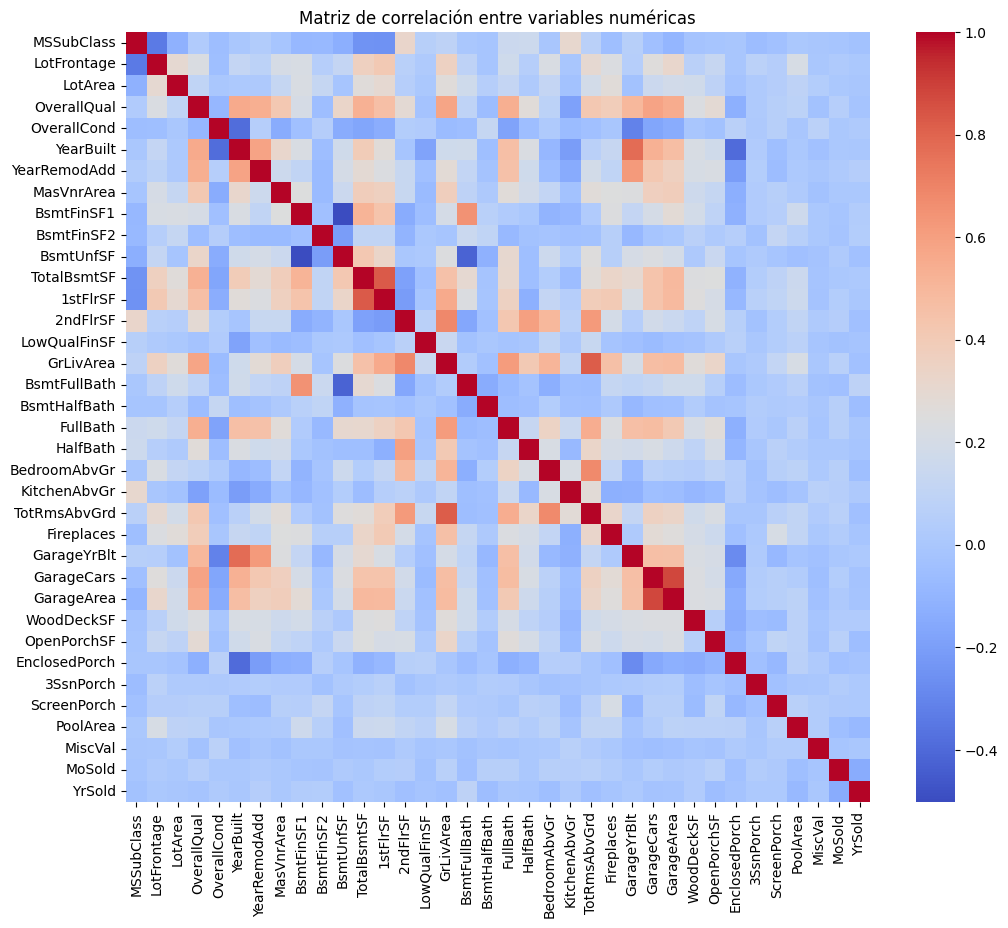

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X_vif.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

## 5. Utilice el modelo con el conjunto de prueba y determine la eficiencia del algoritmo para clasificar.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_train = imputer.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)

X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)

model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy en el conjunto de prueba:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n")
print(classification_report(y_test, y_pred))

Accuracy en el conjunto de prueba: 0.952054794520548

Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       222
           1       0.94      0.86      0.90        70

    accuracy                           0.95       292
   macro avg       0.95      0.92      0.93       292
weighted avg       0.95      0.95      0.95       292



## 6. Explique si hay sobreajuste (overfitting) o no (recuerde usar para esto los errores del conjunto de prueba y de entrenamiento). Muestre las curvas de aprendizaje usando los errores de los conjuntos de entrenamiento y prueba.

### Calcular accuracy en entrenamiento y prueba

In [ ]:
from sklearn.metrics import accuracy_score

# Accuracy en entrenamiento
train_accuracy = accuracy_score(y_train, model.predict(X_train))

# Accuracy en prueba
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy en entrenamiento: {train_accuracy:.4f}")
print(f"Accuracy en prueba: {test_accuracy:.4f}")

Accuracy en entrenamiento: 0.9486
Accuracy en prueba: 0.9521


### Curvas de aprendizaje

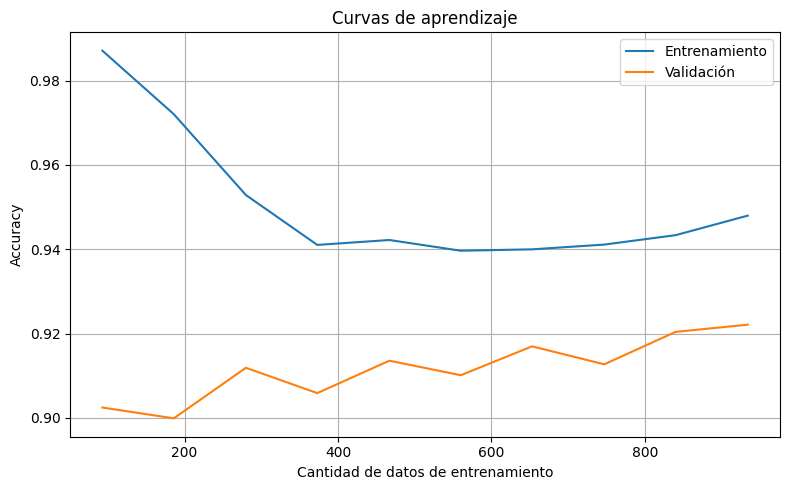

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, label="Validación")
plt.xlabel("Cantidad de datos de entrenamiento")
plt.ylabel("Accuracy")
plt.title("Curvas de aprendizaje")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Accuracy

In [ ]:
Entrenamiento: 94.86%
Prueba: 95.21%

### Conclusión

No hay overfitting. El modelo es bastante estable y generaliza bien. Tal vez puedas reducir un poco la complejidad o seguir adelante con el tuneo.

La curva de entrenamiento comienza muy alta y desciende suavemente. Aunque la curva de validación es más baja, pero estable y ligeramente ascendente al final

## SELECCIÓN DE VARIABLES Y ENCODING
## Puedes ajustar las features según tus columnas relevantes

In [4]:
X = df.select_dtypes(include=[np.number]).drop(columns=["SalePrice"])
y = df['precio_vivienda']

# Llenar NaN con la media (puedes cambiar esto)
X = X.fillna(X.mean())

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 7. TUNING CON GRIDSEARCH




In [5]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [200]
}

grid = GridSearchCV(LogisticRegression(multi_class='multinomial'), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print("🧪 Mejor modelo encontrado:")
print(grid.best_params_)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'mul

🧪 Mejor modelo encontrado:
{'C': 0.1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 8. MATRIZ DE CONFUSIÓN Y MÉTRICAS



 Reporte de Clasificación:
               precision    recall  f1-score   support

      barata       0.76      0.74      0.75        81
        cara       0.91      0.73      0.81        70
       media       0.75      0.83      0.79       141

    accuracy                           0.78       292
   macro avg       0.81      0.77      0.78       292
weighted avg       0.79      0.78      0.78       292



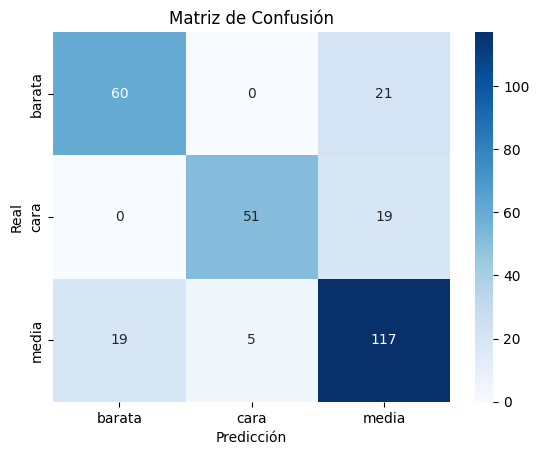

In [6]:
y_pred = best_model.predict(X_test)
print("\n Reporte de Clasificación:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


# 9. MEDICIÓN DE TIEMPO Y USO DE cProfile

In [8]:
def ejecutar_modelo():
    best_model.fit(X_train, y_train)
    best_model.predict(X_test)

pr = cProfile.Profile()
pr.enable()
start = time.time()
ejecutar_modelo()
end = time.time()
pr.disable()

s = io.StringIO()
sortby = pstats.SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats(10)
print("\n Tiempo de ejecución:", round(end - start, 4), "segundos")
print("\n Perfil del modelo (top 10 funciones):\n")
print(s.getvalue())

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 Tiempo de ejecución: 0.2086 segundos

 Perfil del modelo (top 10 funciones):

         29928 function calls (29815 primitive calls) in 0.209 seconds

   Ordered by: cumulative time
   List reduced from 540 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.000    0.000    0.208    0.052 /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3512(run_code)
        4    0.000    0.000    0.208    0.052 {built-in method builtins.exec}
        1    0.000    0.000    0.208    0.208 <ipython-input-8-a3b69c285fd8>:1(ejecutar_modelo)
        1    0.000    0.000    0.202    0.202 /usr/local/lib/python3.11/dist-packages/sklearn/base.py:1372(wrapper)
        1    0.000    0.000    0.201    0.201 /usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1163(fit)
        1    0.000    0.000    0.186    0.186 /usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:54(__call__)
        1 

# 10. AIC y BIC (aproximación)
## AIC = 2k - 2ln(L), BIC = ln(n)k - 2ln(L)
## En lugar de L (log-likelihood), usamos log loss como aproximación

In [9]:
from sklearn.metrics import log_loss

logloss = log_loss(y_test, best_model.predict_proba(X_test))
n = len(X_test)
k = X_test.shape[1]

AIC = 2*k + 2*logloss*n
BIC = np.log(n)*k + 2*logloss*n

print(f"\n AIC: {AIC:.2f}")
print(f" BIC: {BIC:.2f}")


 AIC: 359.42
 BIC: 506.49


# 11. COMPARACIÓN CON OTROS MODELOS
# Aquí deberías insertar tus modelos anteriores (árbol, kNN, etc.)
# Luego comparas: tiempo de ejecución, accuracy, matriz de confusión, AIC/BIC

In [19]:
# Selección de características
X = df.select_dtypes(include='number').drop(columns=['Id', 'SalePrice', 'cara'])
y = df['cara']

# División y preprocesamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
X_train = scaler.fit_transform(imputer.fit_transform(X_train))
X_test = scaler.transform(imputer.transform(X_test))

# Comparación de modelos
resultados = []

# Regresión logística
start = time.time()
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict(X_test)
tiempo_lr = time.time() - start
acc_lr = accuracy_score(y_test, pred_lr)
conf_lr = confusion_matrix(y_test, pred_lr)
resultados.append(("Regresión logística", tiempo_lr, acc_lr, conf_lr))

# Árbol de decisión
start = time.time()
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)
pred_tree = model_tree.predict(X_test)
tiempo_tree = time.time() - start
acc_tree = accuracy_score(y_test, pred_tree)
conf_tree = confusion_matrix(y_test, pred_tree)
resultados.append(("Árbol de decisión", tiempo_tree, acc_tree, conf_tree))

# k-NN
start = time.time()
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
pred_knn = model_knn.predict(X_test)
tiempo_knn = time.time() - start
acc_knn = accuracy_score(y_test, pred_knn)
conf_knn = confusion_matrix(y_test, pred_knn)
resultados.append(("k-NN", tiempo_knn, acc_knn, conf_knn))

# Imprimir resumen
print("\n🧩 Comparación con modelos anteriores:")
for nombre, tiempo, acc, conf in resultados:
    print(f"- {nombre} tardó {tiempo:.4f} segundos y obtuvo accuracy {acc*100:.2f}%")
    print(f"  Matriz de confusión:\n{conf}\n")



🧩 Comparación con modelos anteriores:
- Regresión logística tardó 0.0174 segundos y obtuvo accuracy 95.21%
  Matriz de confusión:
[[218   4]
 [ 10  60]]

- Árbol de decisión tardó 0.0212 segundos y obtuvo accuracy 92.81%
  Matriz de confusión:
[[215   7]
 [ 14  56]]

- k-NN tardó 0.0335 segundos y obtuvo accuracy 93.84%
  Matriz de confusión:
[[217   5]
 [ 13  57]]

